## 004 Pilot RW model alternatives in pymc (single subject)

Date: 22.Jul.2022

### Purpose

Implement 4 RW model alternatives and compare (Standard RW, RW decay, RW fictive, RW separate)

### Outline of Plan

1. Implement RW model from 003
2. Implement RW decay from #1
3. Implement RW fictive from #1
4. Implement RW separate from #1
5. Test that sampling works well for subject 12 (known to be a good subject)

### What we did in this notebook

1. Switched to subject 7 after visually inspecting choice data. Subject 7 has choices that clearly match the reversals in the task.
2. Implemented all RW model alternatives listed above.
3. Plotting pipeline (not method-ized yet!) for posterior traces as well as summary of posterior.
4. Included prior and posterior predictive sampling in the traces.
5. HDI plotting for posterior traces along with true choices to inspect visual matching.
6. Basic single subject LOO and WAIC model comparison using az.compare


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara

from sys import path

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Standard RW model

In [4]:
class RW:
    def __init__(self, longform, summary):
        self.name = 'RW'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, al):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))

            action_probs = self.right_action_probs(alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [5]:
rw_model = RW(longform, df_summary)
rw_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


array([<AxesSubplot:title={'center':'untr_alpha'}>,
       <AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

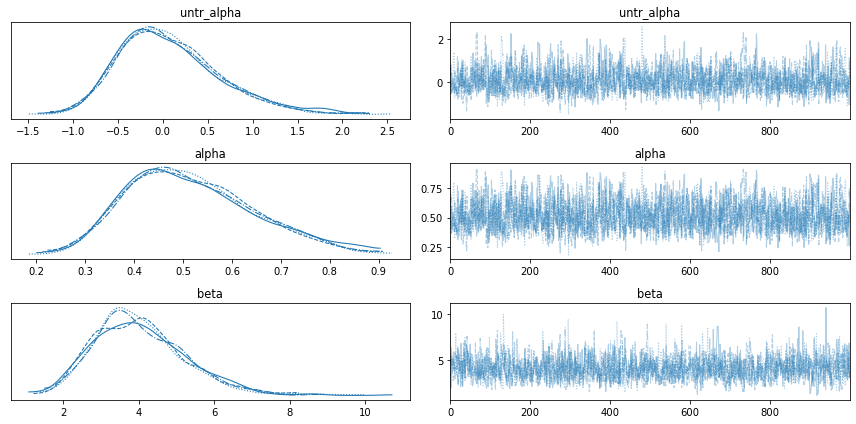

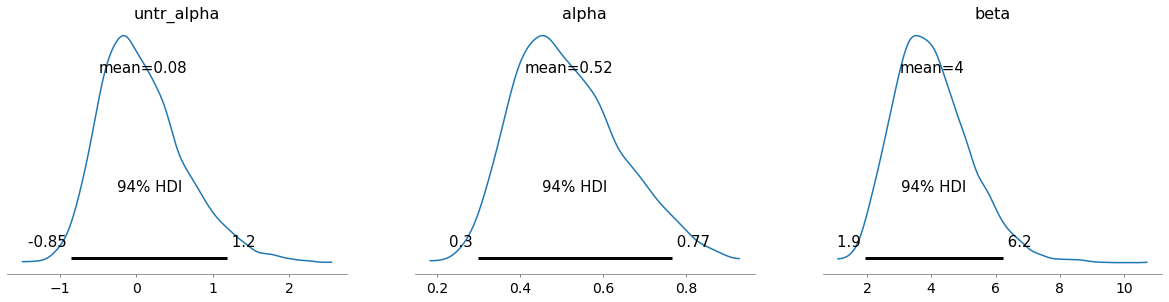

In [99]:
az.plot_trace(rw_model.trace[rw_model.pid_list[7]], var_names=['untr_alpha', 'alpha', 'beta',])
plt.tight_layout()
az.plot_posterior(rw_model.trace[rw_model.pid_list[7]], var_names=['untr_alpha', 'alpha', 'beta'])

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:ylabel='like'>

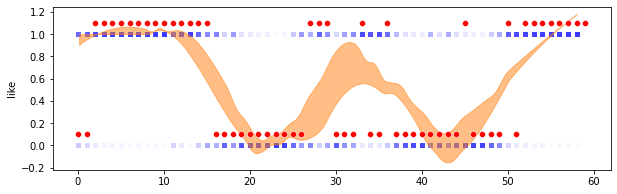

In [100]:
fig = plt.figure(figsize=(10,3))
posterior_pred = rw_model.trace[rw_model.pid_list[7]].posterior_predictive.like[0]
for i, row in enumerate(posterior_pred):
    sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.005)
    if i > 200:
        break
az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60)
pid_act = rw_model.longform[(rw_model.longform['PID']==rw_model.pid_list[7]) & (rw_model.longform['Type']=='other')]['Action'].values
sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red')

## RW Decay model

In [73]:
class RWDecay:
    def __init__(self, longform, summary):
        self.name = 'RWDecay'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, al, d):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        Qs = at.set_subtensor(Qs[1-a], Qs[1-a] + d * (0.5 - Qs[1-a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_decay, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha, sample_decay])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            untr_decay = pm.Normal('untr_decay', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            decay = pm.Deterministic('decay', pm.math.invlogit(untr_decay))

            action_probs = self.right_action_probs(alpha, beta, decay, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [86]:
rwdecay_model = RWDecay(longform, df_summary)
rwdecay_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, untr_decay, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


array([[<AxesSubplot:title={'center':'untr_alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'untr_decay'}>],
       [<AxesSubplot:title={'center':'decay'}>,
        <AxesSubplot:title={'center':'beta'}>, <AxesSubplot:>]],
      dtype=object)

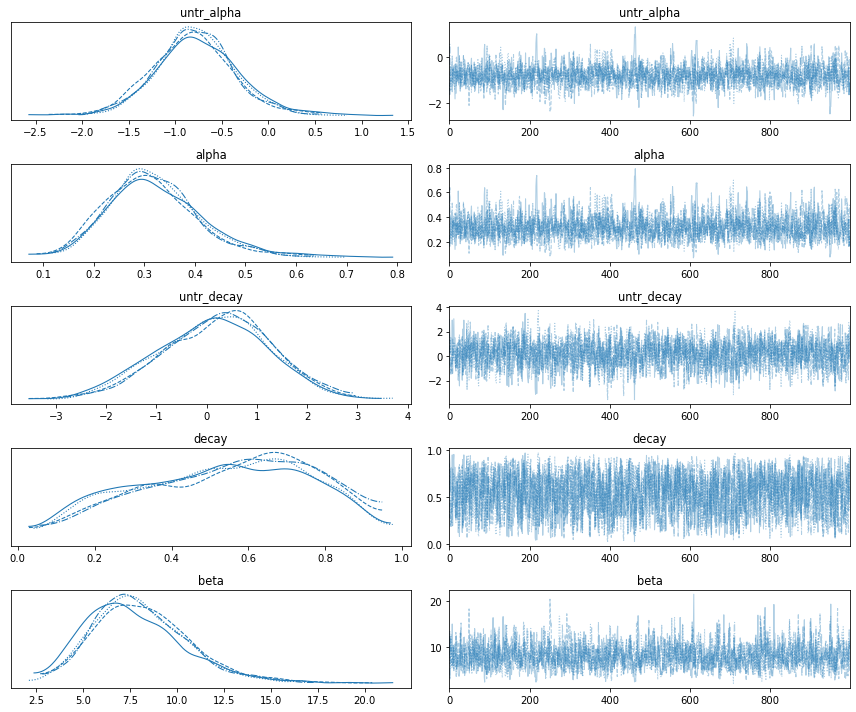

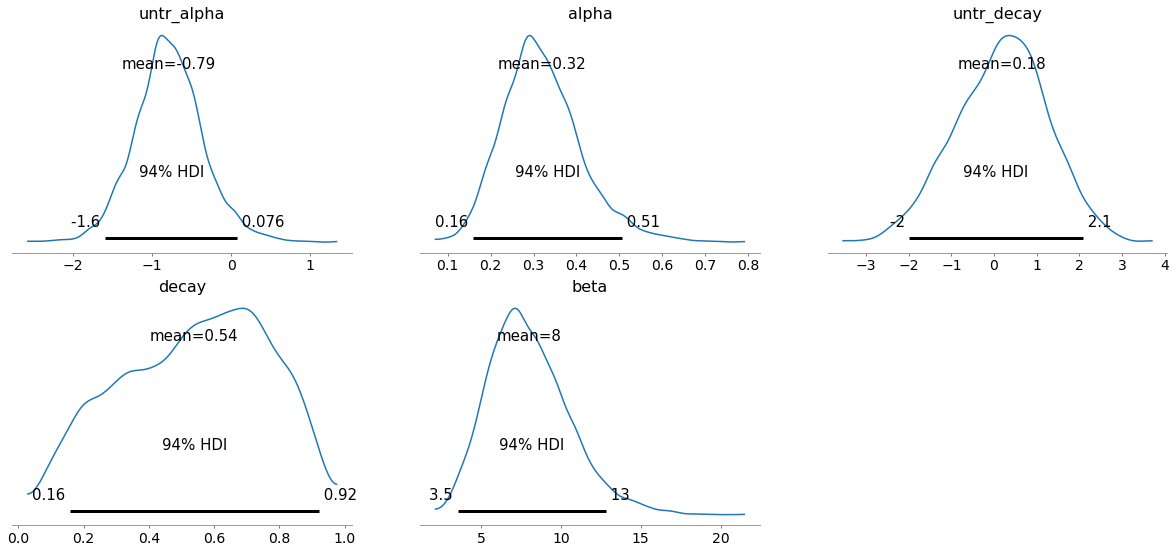

In [89]:
az.plot_trace(rwdecay_model.trace[rwdecay_model.pid_list[7]], var_names=['untr_alpha', 'alpha', 'untr_decay', 'decay', 'beta',])
plt.tight_layout()
az.plot_posterior(rwdecay_model.trace[rwdecay_model.pid_list[7]], var_names=['untr_alpha', 'alpha', 'untr_decay', 'decay', 'beta'])

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:ylabel='like'>

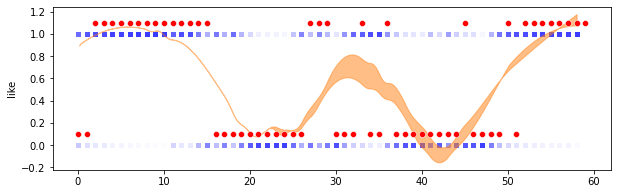

In [95]:
fig = plt.figure(figsize=(10,3))
posterior_pred = rwdecay_model.trace[rwdecay_model.pid_list[7]].posterior_predictive.like[0]
for i, row in enumerate(posterior_pred):
    sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.005)
    if i > 200:
        break
az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60)
pid_act = rwdecay_model.longform[(rwdecay_model.longform['PID']==rwdecay_model.pid_list[7]) & (rwdecay_model.longform['Type']=='other')]['Action'].values
sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red')

## RW Fictive model

In [103]:
class RWFictive:
    def __init__(self, longform, summary):
        self.name = 'RWFictive'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, al, f_al):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        Qs = at.set_subtensor(Qs[1-a], Qs[1-a] + f_al * (r - Qs[a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_fictive_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha, sample_fictive_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            untr_fictive_alpha = pm.Normal('untr_fictive_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            fictive_alpha = pm.Deterministic('fictive_alpha', pm.math.invlogit(untr_fictive_alpha))

            action_probs = self.right_action_probs(alpha, fictive_alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [104]:
rwfictive_model = RWFictive(longform, df_summary)
rwfictive_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, untr_fictive_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'untr_alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'untr_fictive_alpha'}>],
       [<AxesSubplot:title={'center':'fictive_alpha'}>,
        <AxesSubplot:title={'center':'beta'}>, <AxesSubplot:>]],
      dtype=object)

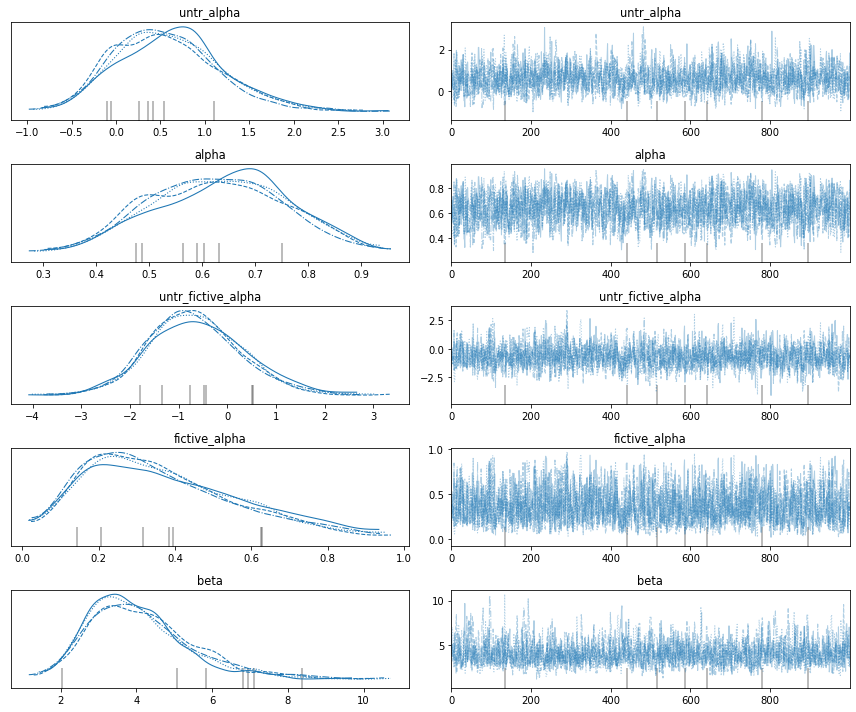

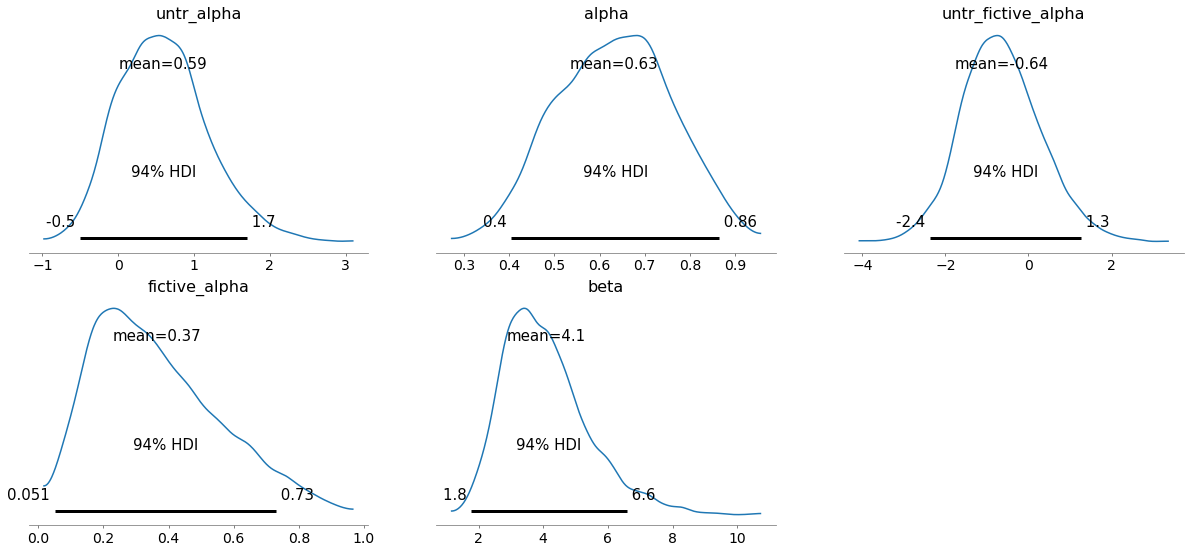

In [105]:
az.plot_trace(rwfictive_model.trace[rwfictive_model.pid_list[7]], var_names=['untr_alpha', 'alpha', 'untr_fictive_alpha', 'fictive_alpha', 'beta',])
plt.tight_layout()
az.plot_posterior(rwfictive_model.trace[rwfictive_model.pid_list[7]], var_names=['untr_alpha', 'alpha', 'untr_fictive_alpha', 'fictive_alpha', 'beta'])

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:ylabel='like'>

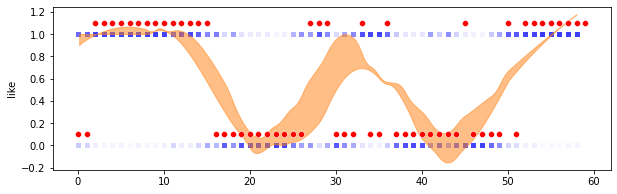

In [106]:
fig = plt.figure(figsize=(10,3))
posterior_pred = rwfictive_model.trace[rwfictive_model.pid_list[7]].posterior_predictive.like[0]
for i, row in enumerate(posterior_pred):
    sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.005)
    if i > 200:
        break
az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60)
pid_act = rwfictive_model.longform[(rwfictive_model.longform['PID']==rwfictive_model.pid_list[7]) & (rwfictive_model.longform['Type']=='other')]['Action'].values
sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red')

## RW Separate +/- PE model

In [111]:
class RWSeparate:
    def __init__(self, longform, summary):
        self.name = 'RWSeparate'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.trace = {}

    def update_Q(self, a, r, Qs, pos_al, neg_al):
        Qs = aesara.ifelse.ifelse(
            at.lt(r-Qs[a], 0),
            at.set_subtensor(Qs[a], Qs[a] + neg_al * (r - Qs[a])),
            at.set_subtensor(Qs[a], Qs[a] + pos_al * (r - Qs[a]))
        )
        
        return Qs

    def right_action_probs(self, sample_pos_alpha, sample_neg_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_pos_alpha, sample_neg_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha_pos = pm.Normal('untr_pos_alpha', mu=0, sigma=1)
            untr_alpha_neg = pm.Normal('untr_neg_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            pos_alpha = pm.Deterministic('pos_alpha', pm.math.invlogit(untr_alpha_pos))
            neg_alpha = pm.Deterministic('neg_alpha', pm.math.invlogit(untr_alpha_neg))

            action_probs = self.right_action_probs(pos_alpha, neg_alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])

            self.trace[pid] = pm.sample()
            self.trace[pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.trace[pid], extend_inferencedata=True)

In [112]:
rwseparate_model = RWSeparate(longform, df_summary)
rwseparate_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_pos_alpha, untr_neg_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


array([[<AxesSubplot:title={'center':'untr_pos_alpha'}>,
        <AxesSubplot:title={'center':'pos_alpha'}>,
        <AxesSubplot:title={'center':'untr_neg_alpha'}>],
       [<AxesSubplot:title={'center':'neg_alpha'}>,
        <AxesSubplot:title={'center':'beta'}>, <AxesSubplot:>]],
      dtype=object)

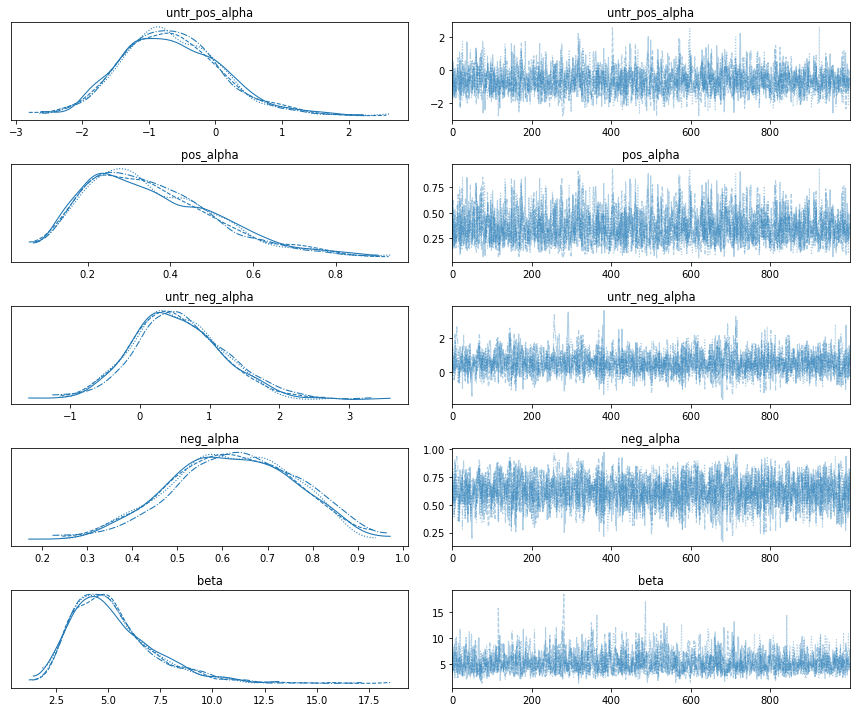

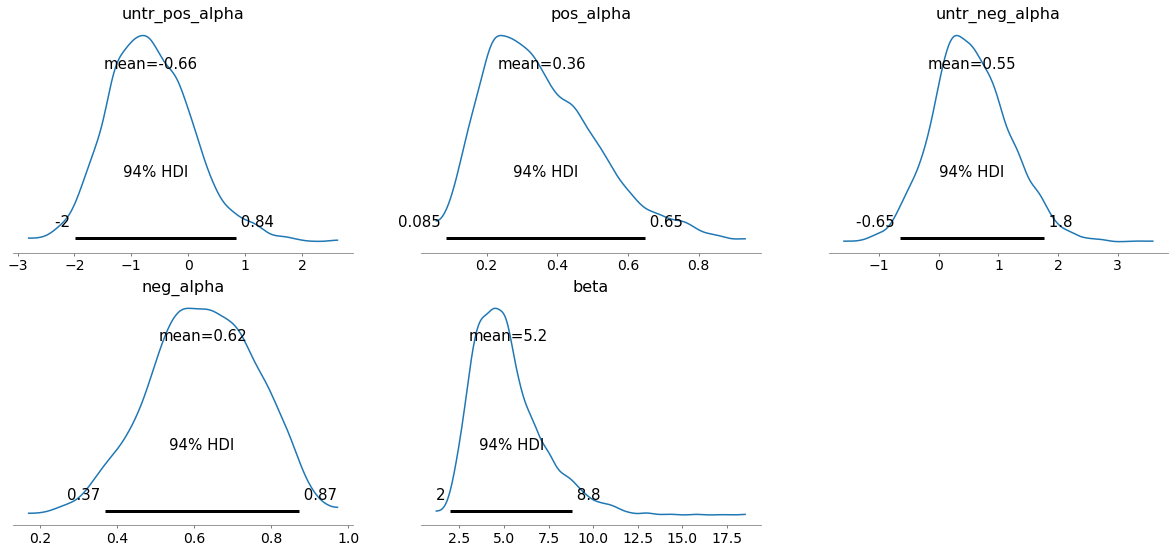

In [114]:
az.plot_trace(rwseparate_model.trace[rwseparate_model.pid_list[7]], var_names=['untr_pos_alpha', 'pos_alpha', 'untr_neg_alpha', 'neg_alpha', 'beta',])
plt.tight_layout()
az.plot_posterior(rwseparate_model.trace[rwseparate_model.pid_list[7]], var_names=['untr_pos_alpha', 'pos_alpha', 'untr_neg_alpha', 'neg_alpha', 'beta'])

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<AxesSubplot:ylabel='like'>

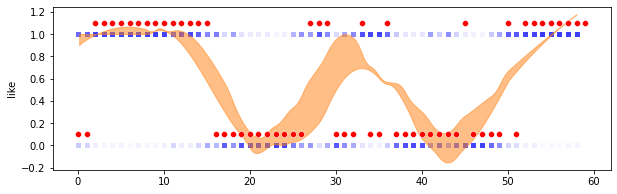

In [ ]:
fig = plt.figure(figsize=(10,3))
posterior_pred = rwseparate_model.trace[rwseparate_model.pid_list[7]].posterior_predictive.like[0]
for i, row in enumerate(posterior_pred):
    sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.005)
    if i > 200:
        break
az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60)
pid_act = rwseparate_model.longform[(rwseparate_model.longform['PID']==rwseparate_model.pid_list[7]) & (rwseparate_model.longform['Type']=='other')]['Action'].values
sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red')

## Model comparison between RW alternatives (LOO)

In [115]:
df_comp_loo = az.compare({
    "rw": rw_model.trace[rw_model.pid_list[7]],
    "rwdecay": rwdecay_model.trace[rwdecay_model.pid_list[7]],
    "rwfictive": rwfictive_model.trace[rwfictive_model.pid_list[7]],
    "rwseparate": rwseparate_model.trace[rwseparate_model.pid_list[7]] 
})
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
rwseparate,0,-23.851026,1.558372,0.000000,9.131878e-01,4.221356,0.000000,False,log
rw,1,-24.475685,1.263376,0.624659,0.000000e+00,4.282220,0.914242,False,log
rwdecay,2,-24.651887,1.651792,0.800861,8.681217e-02,4.230899,1.378684,False,log
rwfictive,3,-25.454010,1.291733,1.602984,2.220446e-16,4.355370,1.113112,False,log


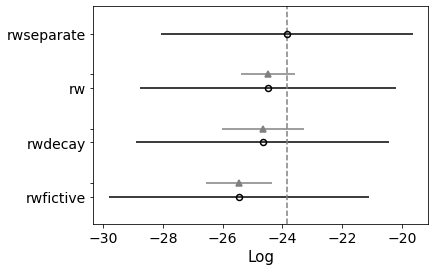

In [118]:
az.plot_compare(df_comp_loo, insample_dev=False);

## Model comparison between RW alternatives (WAIC)

In [119]:
df_comp_waic = az.compare({
    "rw": rw_model.trace[rw_model.pid_list[7]],
    "rwdecay": rwdecay_model.trace[rwdecay_model.pid_list[7]],
    "rwfictive": rwfictive_model.trace[rwfictive_model.pid_list[7]],
    "rwseparate": rwseparate_model.trace[rwseparate_model.pid_list[7]] 
}, ic='waic')
df_comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
rwseparate,0,-23.781706,1.489052,0.000000,9.529835e-01,4.194695,0.000000,False,log
rw,1,-24.459898,1.247589,0.678192,3.080681e-16,4.276778,0.863082,False,log
rwdecay,2,-24.630227,1.630131,0.848521,4.701650e-02,4.224615,1.353370,False,log
rwfictive,3,-25.441942,1.279664,1.660237,0.000000e+00,4.351037,1.069794,False,log


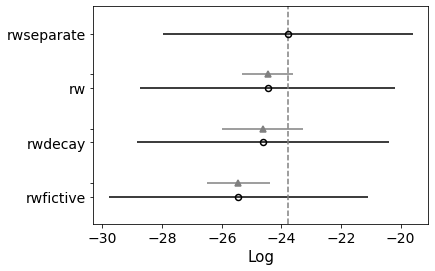

In [120]:
az.plot_compare(df_comp_waic, insample_dev=False);